In [74]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io as scio
import h5py
import numpy as np
import time
import math
import os
import json
from pathlib import Path
from tmm_acc import coh_tmm_normal_spol_spec_d
from  HybridNet import HybridNet, HybnetLoss

dtype = torch.float
device_data = torch.device('cpu')
device_test = torch.device('cuda:0')
# evaluate the model by calculating the MSE of each curve
def evaluate(model, Input, Output):
    model.eval()
    with torch.no_grad():
        Output_pred = model(Input)
        loss_mat = (Output_pred - Output) ** 2
        loss = torch.mean(loss_mat, dim=1)
        return loss.cpu().numpy(), Output_pred.cpu().numpy()

In [30]:
model_folder = Path(r'D:\zf-py\graduate2\PCSED\nets\hybnet\20231016_214733')

with open(model_folder/'config.json',encoding='utf-8') as f:
    config = json.load(f)


fnet_cfg = config['fnet']
PCSED_cfg = config['PCSED']
TFNum = PCSED_cfg['TFNum']

WL = np.arange(fnet_cfg['StartWL'], fnet_cfg['EndWL'], fnet_cfg['Resolution'])

params = scio.loadmat(model_folder/'TrainedParams.mat')['Params']
TargetCurves = scio.loadmat(model_folder/'TargetCurves.mat')['TargetCurves']
TargetCurves_FMN = scio.loadmat(model_folder/'TargetCurves_FMN.mat')['TargetCurves_FMN']
n_array = scio.loadmat(r'D:\zf-py\graduate2\code\coatings\n_L20_R5.0.mat')['n']


model:HybridNet = torch.load(model_folder/'hybnet.pkl')

In [31]:
# show all model params and if leaf
for name,param in filter(lambda p: p[1].requires_grad, model.named_parameters()):
    print(name, param.size(), param.is_leaf)

DesignParams torch.Size([9, 20]) True
SWNet.Linear1.weight torch.Size([500, 9]) True
SWNet.Linear1.bias torch.Size([500]) True
SWNet.Linear2.weight torch.Size([500, 500]) True
SWNet.Linear2.bias torch.Size([500]) True
SWNet.Linear3.weight torch.Size([121, 500]) True
SWNet.Linear3.bias torch.Size([121]) True


In [35]:
for param in filter(lambda p: p.requires_grad, model.DesignParams):
    print(param.size(), param.is_leaf)

torch.Size([20]) False
torch.Size([20]) False
torch.Size([20]) False
torch.Size([20]) False
torch.Size([20]) False
torch.Size([20]) False
torch.Size([20]) False
torch.Size([20]) False
torch.Size([20]) False


In [42]:
params = scio.loadmat(model_folder/'TrainedParams.mat')['Params']
TargetCurves = scio.loadmat(model_folder/'TargetCurves.mat')['TargetCurves']
TargetCurves_FMN = scio.loadmat(model_folder/'TargetCurves_FMN.mat')['TargetCurves_FMN']
n_array = scio.loadmat(r'D:\zf-py\graduate2\code\coatings\n_L20_R5.0.mat')['n']


In [43]:
d_array = np.zeros((params.shape[0],params.shape[1]+2))
d_array += np.inf
d_array[:,1:-1] = params

In [44]:
T = coh_tmm_normal_spol_spec_d(n_array, d_array, WL)

IndexError: index 12 is out of bounds for dimension 1 with size 12

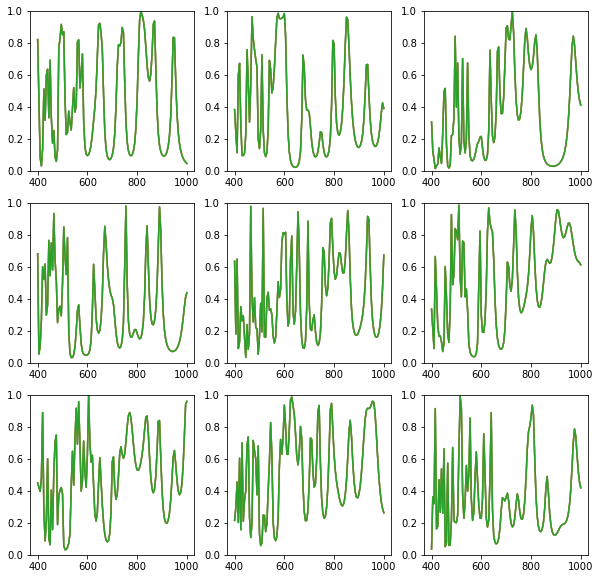

In [40]:
plt.figure(figsize=(10, 10))
for i in range(TFNum):
    plt.subplot(math.ceil(math.sqrt(TFNum)), math.ceil(math.sqrt(TFNum)), i + 1)
    plt.plot(WL, TargetCurves[i, :])
    plt.plot(WL, TargetCurves_FMN[i, :])
    plt.plot(WL, T[i, :])
    plt.ylim(0, 1)
plt.show()

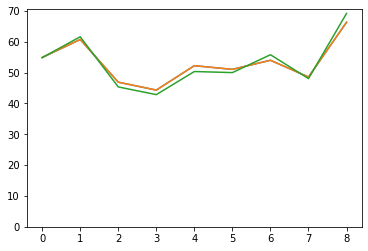

In [11]:
plt.plot(TargetCurves.sum(axis=1))
plt.plot(TargetCurves_FMN.sum(axis=1))
plt.plot(T.sum(axis=1))
plt.ylim(bottom=0)
plt.show()

In [84]:
params_history = scio.loadmat(r'D:\zf-py\graduate2\PCSED\nets\hybnet\20231017_164902\params_history.mat')['params_history']
params_history = params_history.transpose(1,0,2)

In [87]:
params_history.min()

-3.6049304

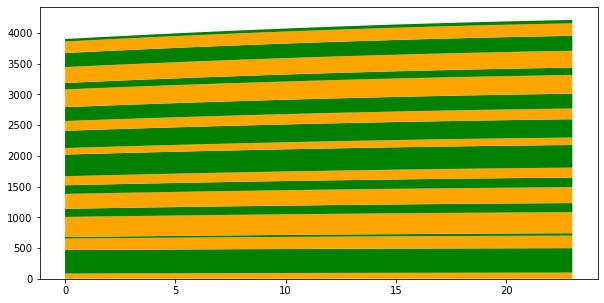

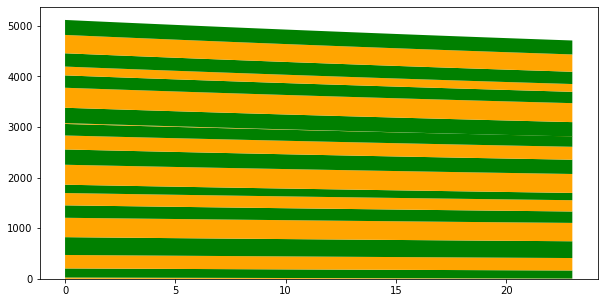

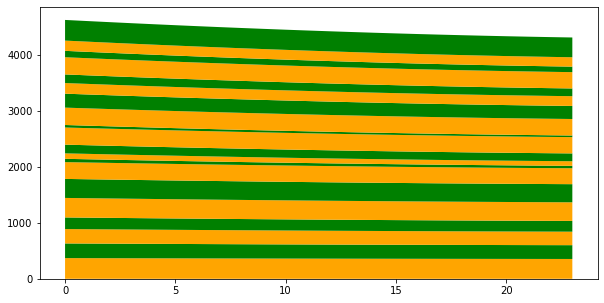

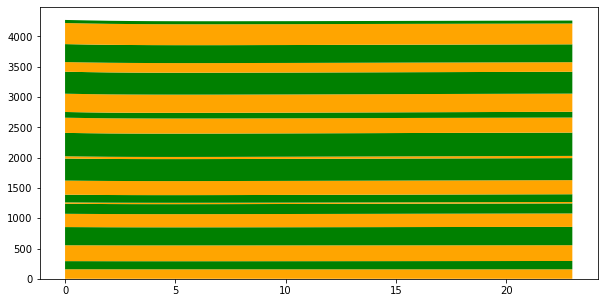

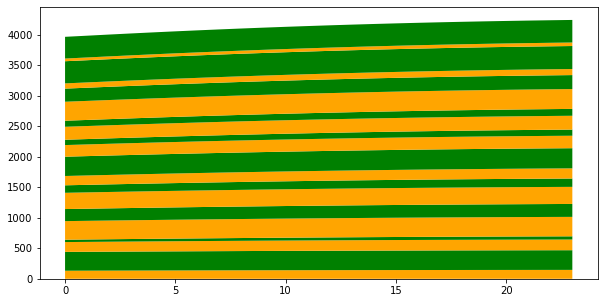

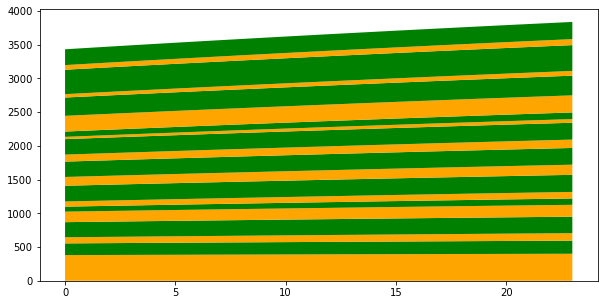

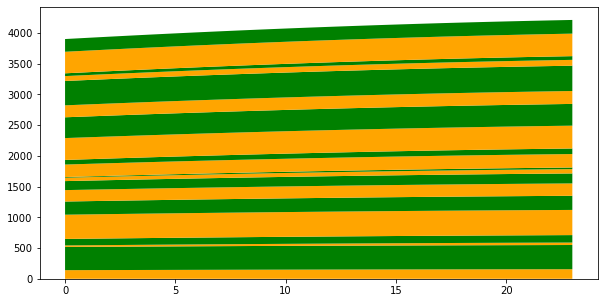

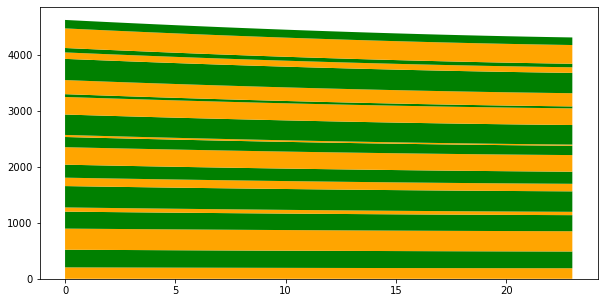

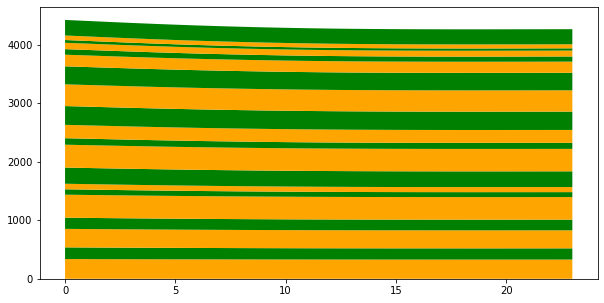

In [86]:
n_TF = params_history.shape[0]

for fidx, params in enumerate(params_history[:,:,:]):
    plt.figure(figsize=(10, 5))

    c,l=[],[]
    for layer in range(params.shape[1]):
        color = 'g' if layer%2 else 'orange'
        c.append(color)
        l.append(params[:,layer])

    plt.stackplot(np.arange(params.shape[0]),*l,colors=c)
    plt.show()


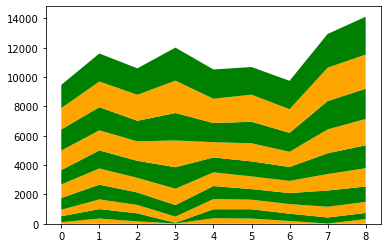

In [46]:
params[:,::1]

array([[129.46777344,  17.27368355, 100.73786163, 357.48406982,
         58.43753052, 115.99341583, 363.54434204,  35.4069519 ,
        294.57583618, 110.77101135],
       [162.60084534, 167.36743164, 211.52545166, 138.33566284,
        125.02050781, 101.12662506, 343.50656128,  14.97799778,
        287.83013916, 357.55187988],
       [ 26.59327888, 375.86514282,  67.61558533, 170.18240356,
        168.91520691, 140.14476013, 279.39257812,  26.36593437,
        379.19238281, 167.10339355],
       [ 47.9258194 , 331.15283203,  50.4453392 , 358.27194214,
        350.93185425, 326.19454956, 367.26257324, 374.15606689,
         22.24745178,  23.95104218],
       [339.24255371, 349.91992188, 264.45635986,  25.62255669,
         80.61652374,  51.33932877, 185.94499207,  82.19258881,
        236.26365662, 378.6902771 ],
       [ 37.88704681, 379.59274292, 232.14190674, 211.01977539,
        156.40690613, 147.52357483,  67.15640259,  16.46649551,
        278.49862671, 357.36303711],
       [32